# Baseline Model:


## Decision Tree Classifer

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.datasets import load_iris

%matplotlib inline

In [4]:
#Load in the dataset
diabetes_df = pd.read_csv('cleaned_diabetes_data.csv', index_col=0)

In [5]:
diabetes_df

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,...,No,No,No,No,No,No,No,No,No,Otherwise
1,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
2,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,...,No,No,No,No,No,No,No,No,Yes,Otherwise
3,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
4,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,Caucasian,Female,[70-80),1,1,7,9,Unknown,Unknown,50,...,No,Steady,No,No,No,No,No,Ch,Yes,Otherwise
101755,Other,Female,[40-50),1,1,7,14,MD,Unknown,73,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise
101756,Other,Female,[60-70),1,1,7,2,MD,Unknown,46,...,No,Steady,No,No,No,No,No,No,Yes,Otherwise
101758,Caucasian,Female,[80-90),1,1,7,5,MC,Unknown,76,...,No,Up,No,No,No,No,No,Ch,Yes,Otherwise


In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import confusion_matrix


#Feature Selection
X = diabetes_df.drop(['readmitted'], axis=1)
y= diabetes_df['readmitted']

#Do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [7]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [8]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [11]:
categorical_feature_names = ['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id','payer_code', 'medical_specialty','diag_1', 'diag_2', 'diag_3','max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide','citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

encoders = {}

for categorical_feature in categorical_feature_names:
    ohe,X_train = encode_and_concat_feature_train(X_train, categorical_feature)
    encoders[categorical_feature] = ohe



In [12]:
encoders

{'race': OneHotEncoder(handle_unknown='ignore'),
 'gender': OneHotEncoder(handle_unknown='ignore'),
 'age': OneHotEncoder(handle_unknown='ignore'),
 'admission_type_id': OneHotEncoder(handle_unknown='ignore'),
 'discharge_disposition_id': OneHotEncoder(handle_unknown='ignore'),
 'admission_source_id': OneHotEncoder(handle_unknown='ignore'),
 'payer_code': OneHotEncoder(handle_unknown='ignore'),
 'medical_specialty': OneHotEncoder(handle_unknown='ignore'),
 'diag_1': OneHotEncoder(handle_unknown='ignore'),
 'diag_2': OneHotEncoder(handle_unknown='ignore'),
 'diag_3': OneHotEncoder(handle_unknown='ignore'),
 'max_glu_serum': OneHotEncoder(handle_unknown='ignore'),
 'A1Cresult': OneHotEncoder(handle_unknown='ignore'),
 'metformin': OneHotEncoder(handle_unknown='ignore'),
 'repaglinide': OneHotEncoder(handle_unknown='ignore'),
 'nateglinide': OneHotEncoder(handle_unknown='ignore'),
 'chlorpropamide': OneHotEncoder(handle_unknown='ignore'),
 'glimepiride': OneHotEncoder(handle_unknown='igno

In [13]:
def encode_and_concat_feature_test(X_test, feature_name, ohe):
    """
    Helper function for transforming test data. It takes in the full X_test dataframe,
    the feature name, and the already fitted encoder from X_train. Returns the transformed
    X_test with that feature encoded into multiple columns of 1s and 0s.
    """
    # Call helper function that encodes the feature using the pre-fitted encoder
    X_test = encode_and_concat_feature(X_test, feature_name, ohe)
    return X_test

# Encode X_test using the fitted encoders
for categorical_feature in categorical_feature_names:
    X_test = encode_and_concat_feature_test(X_test, categorical_feature, encoders[categorical_feature])


In [14]:
X_train.shape, X_test.shape

((52479, 2312), (17494, 2312))

In [15]:
#Initialize LabelEncoder
labenc = LabelEncoder()

#Fit and transform the target variable to the label encoder, which converts the target into numerics
y = labenc.fit_transform(diabetes_df.readmitted)


In [26]:
[x for x in X_train.columns if type(x) == int]

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 12,
 15,
 16,
 17,
 18,
 22,
 23,
 24,
 25,
 27,
 28,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 14,
 17,
 20,
 22,
 25]

In [16]:
tree_classifer = DecisionTreeClassifier(criterion='gini',random_state=42, max_depth = 10 )

tree_classifer.fit(X_train,y_train)

TypeError: Feature names are only supported if all input features have string names, but your input has ['float', 'int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

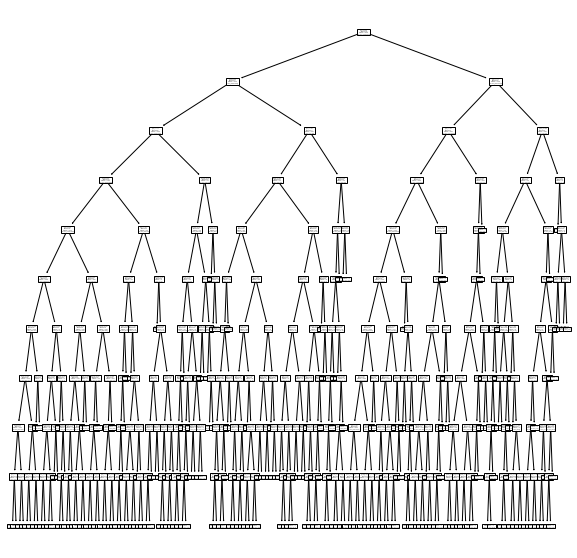

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_classifer, ax=ax);

## Evaluating the Classifier

In [ ]:
tree_classifer.score(X_train,y_train)

0.9183864021799196

We don't want to rely on accuracy to evaluate the model because we have extreme class imbalance

In [ ]:
#get predictions
y_pred = tree_classifer.predict(X_test)

cfmat = confusion_matrix(y_test,y_pred)


In [ ]:
y_pred

array(['Otherwise', 'Otherwise', 'Otherwise', ..., 'Otherwise',
       'Otherwise', 'Otherwise'], dtype=object)

In [ ]:
accuracy_score(y_test, y_pred) *100

90.47101863496056

In [ ]:
cfmat

array([[   40,  1571],
       [   96, 15787]])

Retrieving notices: ...working... done

PackageNotInstalledError: Package is not installed in prefix.
  prefix: /opt/anaconda3/envs/learn-env
  package name: conda



Note: you may need to restart the kernel to use updated packages.


In [ ]:
ConfusionMatrixDisplay(cfmat, display_labels=None)

In [ ]:
from sklearn.metrics import precision_score

precision_score(y_test,y_pred)

Something is wrong :(

In [ ]:
X_test 